In [1]:
import jax
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update('jax_enable_x64', True)
from jax.numpy.linalg import solve, norm
import jax.numpy as jnp
import optimistix as optx

from functools import partial
import matplotlib.pyplot as plt

# Numerical solutions to (stiff) ODEs

Consider the numerical solution of a system of ODEs
$$ \dot{x}(t) = f(t,x(t)) \qquad x(t_0) = x_0 $$

## Runge-Kutta Methods
For an $s$-stage Runge-Kutta method, each integration step can be denoted
$$
\begin{alignat}{3}
    T_i &= t_n + c_i h \qquad && i=1,2, \ldots, s  \\
    X_i &= x_n + h \sum_{j=1}^{s} a_{ij} f(T_j,X_j) \qquad &&
    i=1,2, \ldots, s \\
    x_{n+1} &= x_n + h \sum_{j=1}^{s} b_j f(T_j,X_j) \\
    \hat{x}_{n+1} &= x_n + h \sum_{j=1}^{s} \hat{b}_j f(T_j,X_j)
    \\
    e_{n+1} &= x_{n+1}-\hat{x}_{n+1}= h \sum_{j=1}^{s} d_j
    f(T_j,X_j) \quad && d_j = b_j - \hat{b}_j
\end{alignat}
$$
where $T_i$ and $X_i$ are the internal nodes and states computed by the s-stage Runge-Kutta method. $x_{n+1}$ is the state computed at $t_{n+1}=t_n+h$. $\hat{x}_{n+1}$ is the corresponding state computed by the embedded Runge-Kutta method and $e_{n+1} = x_{n+1} - \hat{x}_{n+1}$ is the estimated error of the numerical solution, i.e. $\|e_{n+1}\|$ is an estimate of the local error, $\|x_{n+1} - x(t_{n+1})\|$ given $x(t_n) = x_n$. The embedded method, $\hat{x}_{n+1}$, uses the same internal stages as the integration method, but the quadrature weights are selected such that the embedded method is of different order, which then provides an error estimate for the lowest order method. 

The $s$-stage Runge-Kutta method is defined by the Butcher tableau
$$
    \begin{array}{l|l}
        c & A \\ \hline
          & b' \\
          & \hat{b}' \\ \hline
          & d'
    \end{array}
    \qquad
    = \qquad
    \begin{array}{l|llll}
        c_1 & a_{11} & a_{12} & \ldots & a_{1s} \\
        c_2 & a_{21} & a_{22} & \ldots & a_{2s} \\
        \vdots & \vdots & \vdots & & \vdots \\
        c_s & a_{s1} & a_{s2} & \ldots & a_{ss} \\ \hline
        & b_1 & b_2 & \ldots & b_s \\
        & \hat{b}_1 & \hat{b}_2 & \ldots & \hat{b}_s \\ \hline
        & d_1 & d_2 & \ldots & d_s
    \end{array}
$$

## Example 0: The usual forward Euler, RK4, RK5(4),...
we leave it (the obvious case) as an exercise for a numerical methods class... also to show that they perform abysmally for stiff problems...

## Example 1: Kværnø 3(2) pair
For stiff problems, computationally "cheap" implicit methods are favourable. The Kvaerno 3(2) pair is a 4-stage 3rd order ESDIRK method with embedded 2nd order error control. The method is defined by the Butcher tableau
$$
\begin{array}{c|cccc}
    0 & 0 & 0 & 0 & 0 \\
    2\gamma & \gamma & \gamma & 0 & 0 \\
    1 & \frac{-4\gamma^2+6\gamma-1}{4\gamma} & \frac{-2\gamma+1}{4\gamma} & \gamma & 0 \\
    1 & \frac{6\gamma-1}{12\gamma} & \frac{-1}{(24\gamma-12)\gamma} & \frac{-6\gamma^2+6\gamma-1}{6\gamma-3} & \gamma \\ \hline
    & \frac{6\gamma-1}{12\gamma} & \frac{-1}{(24\gamma-12)\gamma} & \frac{-6\gamma^2+6\gamma-1}{6\gamma-3} & \gamma \\
    & \frac{-4\gamma^2+6\gamma-1}{4\gamma} & \frac{-2\gamma+1}{4\gamma} & \gamma & 0
\end{array}
$$
with
$$
\gamma = 0.4358665215
$$



In [2]:
def kvaerno_32_step(f, Jf, yi, h, ImplicitSolver ):
  """Kværnø 3(2) ESDIRK 3rd order method with 4 stages and embedded 2nd order error control
    Input:
      f : the rhs function of the ODE f(x)
      Jf: Jacobi matrix, not used in this method
      yi: current solution y_i at time t_i
      h : step size
      ImplicitSolver : put an optimistix non-linear solver here, fastest is "Chord"
    Output:
      yip5, err: time propagated solutions y(t+h): R^(nx1) of order 5 and error from embedded 4th order
  """
  # coefficients
  gamma = 0.4358665215
  c1  = 0.
  c2  = 2*gamma
  c3  = 1.
  c4  = 1.
  a21 = gamma; a22 = gamma
  a31 = (-4*gamma**2+6*gamma-1)/(4*gamma); a32 = (-2*gamma+1)/(4*gamma); a33 = gamma
  a41 = (6*gamma-1)/(12*gamma); a42 = -1/((24*gamma-12)*gamma); a43 = (-6*gamma**2+6*gamma-1)/(6*gamma-3); a44 = gamma
  b1  = a41; b2 = a42; b3 = a43; b4 = a44
  d1  = a41-a31; d2 = a42-a32; d3 = a43-a33; d4 = a44

  # predictors
  θ = 1 / (2 * gamma)
  ap21 = 1.0
  ap31 = 1.0 - θ
  ap32 = θ
  ap41 = a31
  ap42 = a32
  ap43 = gamma

  # non-linear solver options
  max_steps = 10 # we limit the non-linear solver to 10 steps
  throw = False # we disable throws, don't care if non-lin solver does not converge
  # stage 1:
  f1 = f(yi)
  fun_s2 = lambda X2, args: yi + h*(a21*f1+a22*f(X2)) - X2
  X2 = optx.root_find(fun_s2, ImplicitSolver, yi+h*(ap21*f1), throw=throw, max_steps=max_steps).value
  # stage 2:
  f2 = f(X2)
  fun_s3 = lambda X3, args: yi + h*(a31*f(yi)+a32*f2+a33*f(X3)) - X3
  X3 = optx.root_find(fun_s3, ImplicitSolver, yi+h*(ap31*f1+ap32*f2), throw=throw, max_steps=max_steps).value
  # stage 3:
  f3 = f(X3)
  fun_s4 = lambda X4, args: yi + h*(a41*f(yi)+a42*f2+a43*f3+a44*f(X4)) - X4
  X4 = optx.root_find(fun_s4, ImplicitSolver, yi+h*(ap41*f1+ap42*f2+ap43*f3), throw=throw, max_steps=max_steps).value
  # stage 4:
  f4 = f(X4)
  # Advance solution and estimate error
  yip3 = yi + h*(b1*f1+b2*f2+b3*f3+b4*f4)
  err  = h*(d1*f1+d2*f2+d3*f3+d4*f4)

  return yip3, err

## Example 1b: Kværnø 5(4) pair
For much stiffer problems, the Kvaerno 5(4) pair is a 7-stage 5th order ESDIRK method with embedded 4th order error control. The Butcher tableau for 3(2), 4(3), and this 5(4) method can be found in https://cds.cern.ch/record/848108/files/cer-002531442.pdf

In [3]:
def kvaerno_54_step(f, Jf, yi, h, ImplicitSolver ):
  """Kværnø 5(4) ESDIRK 5th order method with 7 stages and embedded 4th order error control
    Input:
      f : the rhs function of the ODE f(x)
      Jf: Jacobi matrix, not used in this method
      yi: current solution y_i at time t_i
      h : step size
      ImplicitSolver : put an optimistix non-linear solver here, fastest is "Chord"
    Output:
      yip5, err: time propagated solutions y(t+h): R^(nx1) of order 5 and error from embedded 4th order
  """

  # coefficients
  gamma = 0.26
  c1  = 0.0; c2  = 0.52; c3  = 1.230333209967908; c4  = 0.8957659843500759; c5  = 0.43639360985864756; c6  = 1.0; c7  = 1.0

  a21 = gamma; a22 = gamma
  a31 = 0.13; a32 = 0.84033320996790809; a33 = gamma
  a41 = 0.22371961478320505; a42 = 0.47675532319799699; a43 = -0.06470895363112615; a44 = gamma
  a51 = 0.16648564323248321; a52 = 0.10450018841591720; a53 = 0.03631482272098715; a54 = -0.13090704451073998; a55 = gamma
  a61 = 0.13855640231268224; a62 = 0.0; a63 = -0.04245337201752043; a64 = 0.02446657898003141; a65 = 0.61943039072480676; a66 = gamma
  a71 = 0.13659751177640291; a72 = 0.0; a73 = -0.05496908796538376; a74 = -0.04118626728321046; a75 = 0.62993304899016403; a76 = 0.06962479448202728; a77 = gamma
  
  b1  = a71; b2 = a72; b3 = a73; b4 = a74; b5 = a75; b6 = a76; b7 = a77
  d1  = a71-a61; d2 = a72-a62; d3 = a73-a63; d4 = a74-a64; d5 = a75-a65; d6 = a76-a66; d7 = a77

  # predictors
  ap21 = 1.0
  ap31 = -1.366025403784441; ap32 = 2.3660254037844357
  ap41 = -0.19650552613122207; ap42 = 0.8113579546496623; ap43 = 0.38514757148155954
  ap51 = 0.10375304369958693; ap52 = 0.937994698066431; ap53 = -0.04174774176601781
  ap61 = -0.17281112873898072; ap62 = 0.6235784481025847; ap63 = 0.5492326806363959
  ap71 = a61; ap72 = a62; ap73 = a63; ap74 = a64; ap75 = a65; ap76 = gamma

  # non-linear solver options
  max_steps = 10 # we limit the non-linear solver to 10 steps
  throw = False # we disable throws, don't care if non-lin solver does not converge

  # stage 1:
  f1 = f(yi)
  fun_s2 = lambda X2, args: (yi - X2)/h + (a21*f1 + a22*f(X2)) 
  X2 = optx.root_find(fun_s2, ImplicitSolver, yi + h*(ap21*f1), throw=throw, max_steps=max_steps).value
  # stage 2:
  f2 = f(X2)
  fun_s3 = lambda X3, args: (yi - X3)/h + (a31*f1 + a32*f2 + a33*f(X3)) 
  X3 = optx.root_find(fun_s3, ImplicitSolver, yi + h*(ap31*f1 + ap32*f2), throw=throw, max_steps=max_steps).value
  # stage 3:
  f3 = f(X3)
  fun_s4 = lambda X4, args: (yi - X4)/h + (a41*f1 + a42*f2 + a43*f3 + a44*f(X4))
  X4 = optx.root_find(fun_s4, ImplicitSolver, yi + h*(ap41*f1 + ap42*f2 + ap43*f3), throw=throw, max_steps=max_steps).value
  # stage 4:
  f4 = f(X4)
  fun_s5 = lambda X5, args: (yi - X5)/h + (a51*f1 + a52*f2 + a53*f3 + a54*f4 + a55*f(X5))
  X5 = optx.root_find(fun_s5, ImplicitSolver, yi + h*(ap51*f1 + ap52*f2 + ap53*f3), throw=throw, max_steps=max_steps).value
  # stage 5:
  f5 = f(X5)
  fun_s6 = lambda X6, args: (yi - X6)/h + (a61*f1 + a62*f2 + a63*f3 + a64*f4 + a65*f5 + a66*f(X6))
  X6 = optx.root_find(fun_s6, ImplicitSolver, yi + h*(ap61*f1 + ap62*f2 + ap63*f3), throw=throw, max_steps=max_steps).value
  # stage 6:
  f6 = f(X6)
  fun_s7 = lambda X7, args: (yi - X7)/h + (a71*f1 + a72*f2 + a73*f3 + a74*f4 + a75*f5 + a76*f6 + a77*f(X7))
  X7 = optx.root_find(fun_s7, ImplicitSolver, yi + h*(ap71*f1 + ap72*f2 + ap73*f3 + ap74*f4 + ap75*f5 + ap76*f6), throw=throw, max_steps=max_steps).value
  # stage 7:
  f7 = f(X7)
  # Advance solution and estimate error
  yip5 = yi + h*(b1*f1 + b2*f2 + b3*f3 + b4*f4 + b5*f5 + b6*f6 + b7*f7)
  err  = h*(d1*f1 + d2*f2 + d3*f3 + d4*f4 + d5*f5 + d6*f6 + d7*f7)

  return yip5, err

# Original Rosenbrock-Wanner 3(2) solver
A disadvantage of implicit RK solvers is the need for a non-linear root finder, which can be computationally expensive. The Rosenbrock-Wanner methods are a class of implicit Runge-Kutta methods that are linearly implicit, i.e. the implicit stage equations can be solved with a matrix inversion. A good overview can be found near page 59 of https://www.math.uni-frankfurt.de/~harrach/lehre/Numerik_von_Differentialgleichungen.pdf.

A commonly used linear-implicit method is the combination of a two-stage $y^{(2)}$ and three-stage $y^{(3)}$ Rosenbrock-Wanner method allowing for embedded error control. This method is known as `ODE23s` in MATLAB. The method is a good choice for stiff problems, and is often used as a default solver in many software packages. 
$$
\begin{align}
k_1 &= (\text{I}-ah\text{J})^{-1}\;f(y_i) \\
k_2 &= (\text{I}-ah\text{J})^{-1}\;\left[f(y_i + hk_1/2) -ah\text{J}\cdot k_1\right] \\
k_3 &= (\text{I}-ah\text{J})^{-1}\;\left[f(y_i + hk_2) -d_{31} h\text{J}\cdot k_1 -d_{32}   h\text{J}\cdot  k_2\right] \\
y^{(2)}_{i+1} &= y_i + h k_2 \\
y^{(3)}_{i+1} &= y_i + \tfrac{h}{6} \left(k_1 + 4k_2 + k_3 \right) 
\end{align}
$$
where
$$
J = f'(y_i) \quad  a:=\frac{1}{2+\sqrt{2}}, \quad d_{31} = -\frac{4+\sqrt{2}}{2+\sqrt{2}}, \quad d_{32} = \frac{6+\sqrt{2}}{2+\sqrt{2}}
$$


In [4]:
def row_32_step(f, Jf, yi, h, ImplicitSolver=None ):
  """Original Rosenbrock-Wanner method of order 3/2
    Input:
      f : the rhs function of the ODE f(x)
      Jf: Jacobi matrix J(x) of f: R^(nx1) -> R^(nxn) 
      yi: current solution y_i at time t_i
      h : step size
      ImplicitSolver : dummy, not used in this method
    Output:
      yip3, err: time propagated solutions y(t+h): R^(nx1) of order 3 and error from embedded 2nd order
  """
  n  = yi.shape[0]
  sqrt2 = jnp.sqrt(2)
  # coefficients
  a  = 1/(2 + sqrt2)
  d31 = - (4 + sqrt2) / (2 + sqrt2)
  d32 = (6 + sqrt2) / (2 + sqrt2)

  # linear inverse
  I  = jnp.eye(n)
  J  = Jf(yi)
  A  = I - a * h * J
  LU_and_piv = jax.scipy.linalg.lu_factor(A, overwrite_a=True, check_finite=False)

  # stage 1
  b1 = f( yi )
  k1 = jax.scipy.linalg.lu_solve( LU_and_piv, b1 )
  # stage 2
  hJk1 = h * J@k1
  b2 = f( yi + 0.5 * h * k1 )  - a * hJk1
  k2 = jax.scipy.linalg.lu_solve( LU_and_piv, b2 )
  # stage 3
  hJk2 = h * J@k2
  b3 = f( yi + h * k2 ) - d31 * hJk1 - d32 * hJk2
  k3 = jax.scipy.linalg.lu_solve( LU_and_piv, b3 )
  # Advance solution
  yip3 = yi + h/6 * (k1 + 4*k2 + k3)
  yip2 = yi + h * k2
  return yip3, yip3-yip2

# Generalized Rosenbrock-Wanner methods

Following Hairer \& Wanner, ROW methods are defined as solutions of the type
$$
\begin{align}
y_{n+1} &= y_n + \sum_{i=1}^s c_i k_i \\
\left(\text{I}-\gamma h f'(y_n)\right)\cdot k_i &= h\; f\left(y_n + \sum_{j=1}^{i-1}\alpha_{ij}k_j\right) + h f'(y_n) \sum_{j=1}^{i-1}\gamma_{ij}k_j 
\end{align}
$$
Kaps \& Rentrop (1979, retrievable here: http://numerik.mi.fu-berlin.de/wiki/WS_2021/NumericsII_Dokumente/Kaps-Rentrop1979_Article_GeneralizedRunge-KuttaMethodsO.pdf) propose the following 4th order method 'GRK4T' with $\gamma=0.231$
$$
\begin{align}
\gamma_{21} &= -0.270629667752 &&&&\\
\gamma_{31} &= 0.311254483294 & \gamma_{32} &= 0.0085244562848 &&\\
\gamma_{41} &= 0.282816832044 & \gamma_{42} &= -0.457959483281 & \gamma_{43} &=-0.111208333333 \\
\alpha_{21} &= 0.462 &&&&\\
\alpha_{31} &= -0.0815668168327 & \alpha_{32} &= 0.961775150166 &&\\
\hat{c}_1 &= -0.717088504499 & \hat{c}_2 &= 1.77617912176 & \hat{c}_3 &= -0.0590906172617\\
c_1 &= 0.217487371653 & c_2 &= 0.486229037990 & c_3 &= 0 & c_4 &= 0.296283590357
\end{align}
$$

In [5]:
def grkt_43_step( f, Jf, yi, h, ImplicitSolver=None ):
  """GRKT 4(3) method from Kaps & Rentrop 1979
    Input:
      f : the rhs function of the ODE f(x)
      Jf: Jacobi matrix J(x) of f: R^(nx1) -> R^(nxn) 
      yi: current solution y_i at time t_i
      h : step size
      ImplicitSolver : dummy, not used in this method
    Output:
      yip3, err: time propagated solutions y(t+h): R^(nx1) of order 3 and error from embedded 2nd order
  """
  n  = yi.shape[0]
  gamma   = 0.231
  gamma21 = -0.270629667752
  gamma31 = 0.311254483294; gamma32 = 0.00852445628482
  gamma41 = 0.282816832044; gamma42 = -0.457959483281; gamma43 =-0.111208333333

  alpha21 = 0.462
  alpha31 = -0.0815668168327; alpha32 = 0.961775150166
  #alpha41 = alpha31; alpha42 = alpha32; alpha43 = 0.0 # not needed since duplicate coefficients
  chat1   = -0.717088504499; chat2 = 1.77617912176; chat3 = -0.0590906172617
  c1      = 0.217487371653; c2 = 0.486229037990; c3 = 0.; c4 = 0.296283590357

  I  = jnp.eye(n)
  J  = Jf(yi)
  A  = I - gamma * h * J

  LU_and_piv = jax.scipy.linalg.lu_factor(A, overwrite_a=True, check_finite=False)

  # k1
  f1 = f( yi )
  b1 = f1
  k1 = jax.scipy.linalg.lu_solve( LU_and_piv, b1 )

  # k2 
  f2 = f( yi + h * alpha21 * k1 )
  b2 = f2 + h * J @ (gamma21 * k1)
  k2 = jax.scipy.linalg.lu_solve( LU_and_piv, b2 )

  # k3
  f3 = f( yi + h * (alpha31 * k1 + alpha32 * k2) )
  b3 = f3 + h * J @ (gamma31 * k1 + gamma32 * k2)
  k3 = jax.scipy.linalg.lu_solve( LU_and_piv, b3 )

  # k4
  f4 = f3 # this is true by choice in the method and avoids a 4th call to f(.)
  b4 = f4 + h * J @ (gamma41 * k1 + gamma42 * k2 + gamma43 * k3)
  k4 = jax.scipy.linalg.lu_solve( LU_and_piv, b4 )
  
  # Advance
  yip4 = yi + h * ( c1 * k1 + c2 * k2 + c4 * k4 ) # + c3 * k3 (is zero)
  yip3 = yi + h * ( chat1 * k1 + chat2 * k2 + chat3 * k3 )

  return yip4, yip4-yip3


# Adaptive integration with embedded solvers
The error estimate of the embedded method can be used to adapt the step size. The step size is adapted such that the error estimate is within a user-defined tolerance. If the error estimate is too large, the step size is reduced, otherwise it is increased. The following code implements an adaptive integrator using the embedded method to regulate the step size

In [6]:
# @partial( jax.jit, static_argnames=( 'f', 'psilow', 'psihigh', 'nstep_max') )
# def odeintadapt( *, f, psilow, psihigh, t0, t1, y0, nstep_max=8192, reltol, abstol, norm = jnp.linalg.norm ):
@partial( jax.jit, static_argnames=( 'f', 'method', 'nstep_max') )
def odeintadapt( *, f, method, t0, t1, y0, nstep_max=8192, reltol, abstol, norm = jnp.linalg.norm, ImplicitSolver=None ):
  """Adaptive ODE solver
    Input:
      rhs: right hand side of the ODE
      psilow: low order method
      psihigh: high order method
      t0: initial time
      t1: final time
      y0: initial value
      reltol: relative tolerance
      abstol: absolute tolerance
    Output:
      y: solution at time t1
  
  """
  h0 = (t1-t0)/(100*(jnp.linalg.norm(y0)+0.1))
  hmin = h0 / 1e4

  if method == 'Rosenbrock32':
    method_fun = row_32_step
    df = jax.jacfwd(f)
    ImplicitSolver = None

  elif method == 'GRKT43':
    method_fun = grkt_43_step
    df = jax.jacfwd(f)
    ImplicitSolver = None

  elif method == 'Kvaerno32':
    method_fun = kvaerno_32_step
    df = None
    ImplicitSolver = optx.Chord(rtol=reltol, atol=abstol)

  elif method == 'Kvaerno54':
    method_fun = kvaerno_54_step
    df = None
    ImplicitSolver = optx.Chord(rtol=reltol, atol=abstol)
    
  else:
    method_fun = kvaerno_32_step
    df = None
    ImplicitSolver = optx.Chord(rtol=reltol, atol=abstol)


  # initial values
  fy0 = f(y0)
  yi = y0.copy()
  ti = t0
  hi = h0
  n = y0.shape[0]

  # Storage
  ys = jnp.zeros((nstep_max, n))
  es = jnp.zeros((nstep_max, n))
  ts = jnp.zeros(nstep_max)

  ys = ys.at[0].set( yi )
  es = es.at[0].set( 0 )
  ts = ts.at[0].set( ti )

  # Main loop
  def loop_body( arg ):
    yi, ti, hi, ys, es, ts, isave = arg

    # don't step beyond final time
    hi = jnp.minimum( hi, t1 - ti )
    # get step proposal and error estimate from embedded method
    yH, err = method_fun( f, df, yi, hi, ImplicitSolver )
    est = norm(err)

    # save old time variable
    tiold = ti

    # error control bound condition
    hi,ti = jax.lax.cond( est < jnp.minimum(reltol * norm(yH), abstol),
                        lambda _: (hi/0.5,ti+hi), lambda _: (hi*0.5,ti), None )
    
    # function to save the current step's result in the ys,es,ts vectors
    def save( ys, es, ts, yi, est, ti, isave ):
      ys = ys.at[isave].set( yi )
      es = es.at[isave].set( est )
      ts = ts.at[isave].set( ti )
      isave = isave + 1
      return yi, ys, es, ts, isave
    
    # function to ignore the current step (if error bound not matched) and pass through previous result
    def dont_save( ys, es, ts, yi, est, ti, isave ):
      return yi, ys, es, ts, isave

    yi, ys, es, ts, isave = jax.lax.cond( tiold < ti, lambda _: save(ys, es, ts, yH, est, ti, isave), lambda _: dont_save(ys, es, ts, yi, est, ti, isave), None )

    return yi, ti, hi, ys, es, ts, isave
  
  # execute the main loop
  yi, ti, hi, ys, es, ts, isave = jax.lax.while_loop( lambda args: args[1] < t1, loop_body, (yi, ti, hi, ys, es, ts, 1) )
  return ys, ts, es, isave
  


# set ODE test problem, ICs, and other hyperparameters of integration

In [7]:
# van der Pol oscillator RHS of ODE:
mu = 100.
rhs = lambda y: jnp.array([y[1], mu*(1-y[0]**2)*y[1]-y[0]])
t0, t1 = 0., 3*mu

# # harmonic oscillator RHS of ODE: (this is trivial for explicit integrators, but all fail at energy conservation unless symplectic)
# rhs = lambda y: jnp.array([y[1], -y[0]])
# t0, t1 = 0., 4*jnp.pi

# set up ICs
y0 = jnp.array([2., 0.])

# specify error control bounds
reltol = 1e-3
abstol = 1e-3

# Determine timing results for all methods

In [8]:
# lo
for method in ['Kvaerno54', 'Kvaerno32', 'GRKT43', 'Rosenbrock32']:
  ys, ts, es, isteps = odeintadapt( f=rhs, method=method, t0=t0, t1=t1, y0=y0, reltol=reltol, abstol=abstol )
  print('Timing of method1 = \'',method, '\': method required ', isteps, ' steps to solution')
  %timeit ys, ts, es, isteps = odeintadapt( f=rhs, method=method, t0=t0, t1=t1, y0=y0, reltol=reltol, abstol=abstol )

Timing of method1 = ' Kvaerno54 ': method required  170  steps to solution
285 ms ± 211 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Timing of method1 = ' Kvaerno32 ': method required  793  steps to solution
449 ms ± 814 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Timing of method1 = ' GRKT43 ': method required  343  steps to solution
72.7 ms ± 612 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Timing of method1 = ' Rosenbrock32 ': method required  573  steps to solution
106 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Plot solution of two different methods to visualize order vs. number of steps

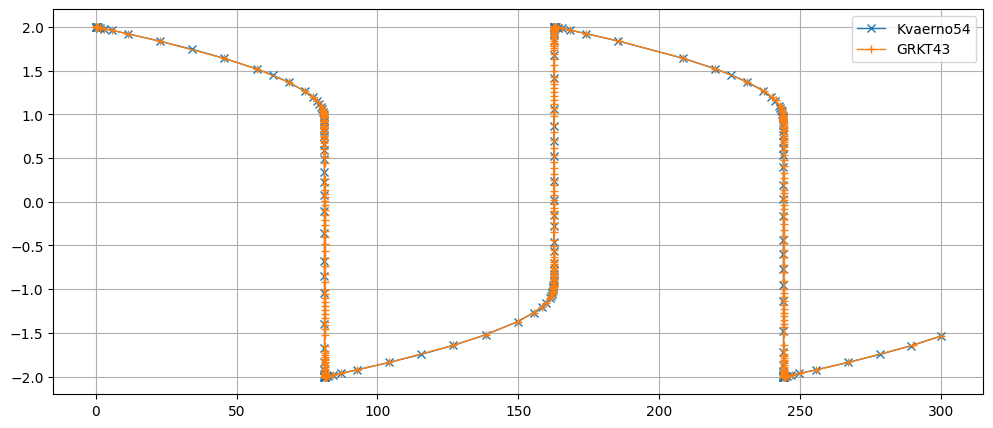

In [9]:
method1 = 'Kvaerno54'
method2 = 'GRKT43'
ys, ts, es, isteps = odeintadapt( f=rhs, method=method1, t0=t0, t1=t1, y0=y0, reltol=reltol, abstol=abstol )
ys2, ts2, es2, isteps2 = odeintadapt( f=rhs, method=method2, t0=t0, t1=t1, y0=y0, reltol=reltol, abstol=abstol )

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(ts[:isteps], ys[:isteps,0], 'x-', lw=1, label=method1)
ax.plot(ts2[:isteps2], ys2[:isteps2,0], '+-', lw=1, label=method2)

ax.legend()
ax.grid()


Text(0, 0.5, 't')

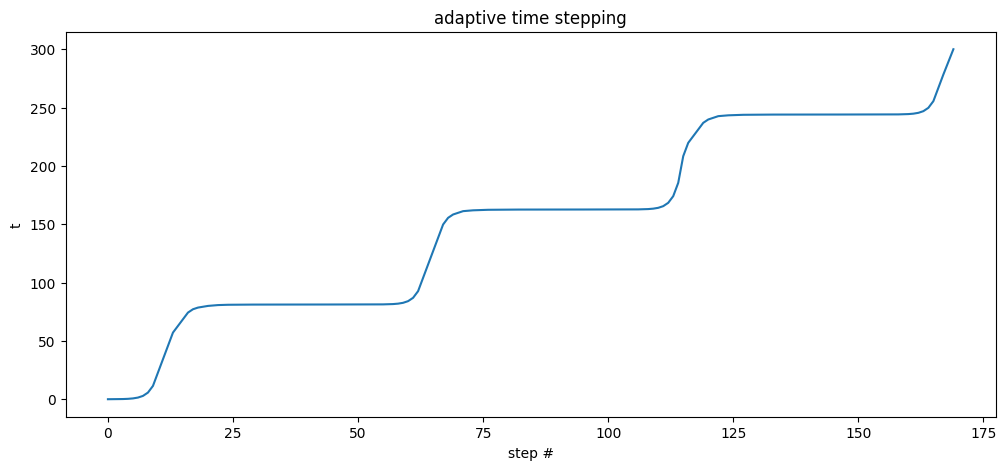

In [10]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(ts[:isteps])
ax.set_title('adaptive time stepping')
ax.set_xlabel('step #')
ax.set_ylabel('t')